# Field methods in remote sensing: Modelling of leaf spectra

- **Prerequisites:** You should have access to the data collected in the field and in the laboratory. You should have finished practical 9.1_ENGN3903_Modelling_Leaf_spectra, and should have access to Google Earth Engine.


## Aims of the practical session

The aim of this practical is to show the differences between satellite spectra, simulated leaf spectra, and leaf spectra collected in the field.

For this activity, we will use the data you collected in the field, the simulated spectra from previous the practical, and Sentinel 2 data from Google Earth Engine.  

## Description

To achieve the aims above, 

First we will:
- Load a Sentinel 2 image of the Arboretum region.
- Plot the leaf spectra collected in the field,
- Plot the simulated leaf spectra from PROSPECT

Then we will:
- Compare the simulated spectra and spectra collected in the field with the spectral signature of a Sentinel 2 image collected over the Arboretum.

Finally you will answer some questions.

Let's do it!

***

## Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import glob
import ee
import geemap as gmap

### Connect to Google Earth Engine (GEE)

Connect to the GEE so we can access GEE datasets and computing assets.
You may be required to input your Google account name and password. Please keep those safe and don't share them with anyone.

In [ ]:
m = gmap.Map()

## Analysis Parameters

In [2]:
# a short date-range around the time you want the image for
date_range = '2022-09-01','2022-09-30'

#A geojson that defines the analysis extent
geojson = 'https://raw.githubusercontent.com/nicolasyounes/engn3903/main/week8/anu_research_forest.geojson'

#the bands from Sentinel-2 that you want
bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

#The Projection system to save the data in
crs = 'EPSG:3577'

## Open Geometery defining AOI

In [3]:
geometry = gmap.geojson_to_ee(geojson)

Could not convert the geojson to ee.Geometry()


Exception: string indices must be integers

## Load Sentinel 2 image

In [4]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    return image.updateMask(mask).divide(10000) #re-scale 


s2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(geometry)
    .filterDate(date_range[0], date_range[1]) 
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) #filter out very cloudy images
    .map(maskS2clouds) #map the cloudmasking/rescaling function
    .select(bands)
    .median() #collapse time-dimension using median statistic
    .clip(geometry)
)

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

## Visualize image

In [5]:
# Lastly, let's give some visualization paramaters to each collection.
s2VisParam = {'bands': ["B4","B3","B2"],
              'max': 0.3,
              'min': 0}


# Let's add the polygon to the map
Map = gmap.Map(center=[-35.30339, 149.06204], zoom=15)              
Map.addLayer(s2, s2VisParam, 's2')
Map.addLayerControl()
Map

Enter verification code: 


Exception: Problem requesting tokens. Please try again.  HTTP Error 400: Bad Request b'{\n  "error": "invalid_request",\n  "error_description": "Missing required parameter: code"\n}'

## Extract the spectral signature of trees in the Arboretum.

**Excercise tip:** Use all bands except for (B1, B9, and B10) for this excercise. You can find more information [here](https://docs.dea.ga.gov.au/notebooks/DEA_datasets/Sentinel_2.html), and [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric).

**Excercise tip:** If you need to remember how to do this, look at the practicals from week 2.


In [6]:
# Here, we'll create a pandas DataFrame indexed by Land Cover Type
# Locate the Eucalyptus forest in the Arboretum, and add it to the list of land covers,
# Use the inspector tool to find the values of several pixels of the Eucalyptus forest,
# Add the values from the inspector tool to the 'pixelValues' dictionary.
# You can also add other vegetation types for comparison.

landCover = ['Eucalypt_pixel1',
             'Eucalypt_pixel4',
             'Eucalypt_pixel3',
             'Eucalypt_pixel2',
            # Add more rows if required
            ]

pixelValues = {
    'Band2': [0.3 , 0.8, 0.08, 0.0],
    'Band3': [0.5, .3, .04, .5],
    'Band4': [.2, .2, .3, .4],
    'Band7': [.1, .2, .3, .3],
        # Add other bands if required
       }

# Now we create a pandas DataFrame, using the 'data' dictionary
df = pd.DataFrame(pixelValues, index = landCover)
df

,Band2,Band3,Band4,Band7
Eucalypt_pixel1,0.30,0.50,0.2,0.1
Eucalypt_pixel4,0.80,0.30,0.2,0.2
Eucalypt_pixel3,0.08,0.04,0.3,0.3
Eucalypt_pixel2,0.00,0.50,0.4,0.3


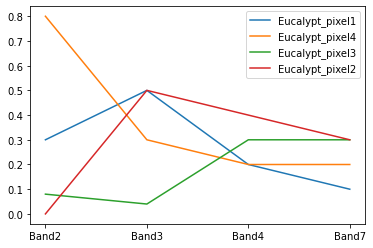

In [7]:
fig, ax = plt.subplots()

# We plot the data on each row independently
for index, row in df.iterrows():
    ax.plot(row, label = row.name)
plt.legend()
plt.show()

## Plot the simulated and field leaf spectra

See practical 9.1_ENGN3903_Modelling_Leaf_spectra if you need a refresher on how to do this.
<div class="alert alert-block alert-warning">
**Excercise tip:** Use only the simulated spectra where you changed all the parameters, that is, the most realistic simulations you created.
    
</div>


In [8]:
# Change the folder path to whereever you saved the spectra from PROSPECT
folder = 'C:/UserData/younescn/Downloads/spectra/' 

# Find all `*.TXT` files in the directory or folder
file_list = [folder+file for file in os.listdir(folder) if file.endswith('.txt')]

# Print the number of `*.txt` files in the folder
print('there are ', len(file_list), ' *.txt files in ', folder)

there are  12  *.txt files in  C:/UserData/younescn/Downloads/spectra/


In [9]:
dfs=[]
for i in range(0,len(file_list)-2):
    data = pd.read_fwf(file_list[i], sep=' ',widths=[4,7,7], 
                  header=None, 
                  names=["Wavelength", "Reflectance", "Transmittance"]
                      ).drop(['Transmittance'], axis=1)
    #data['Wavelength'].astype('int64')
    data.set_index('Wavelength', inplace=True)
    dfs.append(data)
    # print(data)

main_dataframe = pd.concat(dfs, axis = 1)
main_dataframe

,Reflectance,Reflectance,Reflectance,Reflectance,Reflectance,Reflectance,Reflectance,Reflectance,Reflectance,Reflectance
Wavelength,,,,,,,,,,
400,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410
401,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410
402,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411
403,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411
404,0.0412,0.0412,0.0412,0.0412,0.0412,0.0412,0.0412,0.0412,0.0412,0.0412
...,...,...,...,...,...,...,...,...,...,...
2496,0.0189,0.0189,0.0189,0.0189,0.0189,0.0158,0.0154,0.0153,0.0183,0.0181
2497,0.0188,0.0188,0.0188,0.0188,0.0188,0.0158,0.0154,0.0153,0.0183,0.0180
2498,0.0188,0.0188,0.0188,0.0188,0.0188,0.0158,0.0154,0.0154,0.0183,0.0181


<AxesSubplot:title={'center':'Simulated leaf spectra using PROSPECT'}, xlabel='Wavelength'>

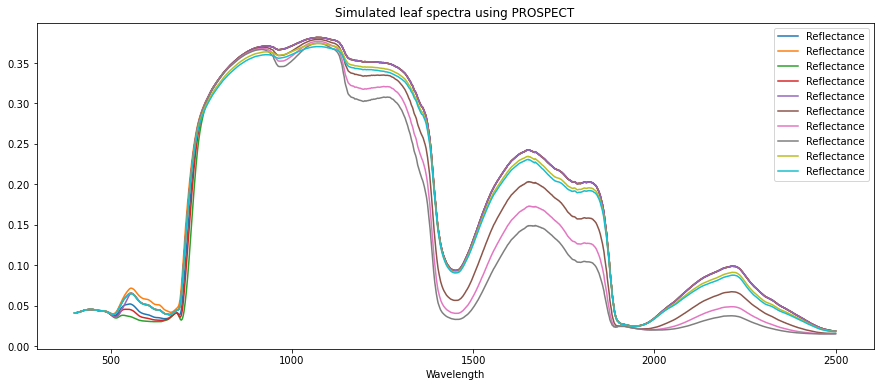

In [10]:
main_dataframe.plot.line(figsize=(15,6),
                        title = 'Simulated leaf spectra using PROSPECT')

## Load and Plot the measured spectra

In [11]:
# Lets read the first file and see what it looks like
# remember to change the names of the files you're using.
measured_spectra1 = pd.read_csv(folder+'/MAC_ARB_098_044_210422_L00001.asd.txt',
                                      sep='\t',)

measured_spectra2 = pd.read_csv(folder+'/MAC_ARB_098_xx4_310321_L00001.asd.txt',
                               sep='\t')

measured_spectra1.set_index('Wavelength', inplace=True)
measured_spectra2.set_index('Wavelength', inplace=True)

measured_spectra1.head()

,MAC_ARB_098_044_210422_L00001.asd
Wavelength,
350,0.610726
351,0.480991
352,-0.188762
353,-0.242855
354,0.072172


## Plot the three types of spectra (satellite, simulated, and measured)

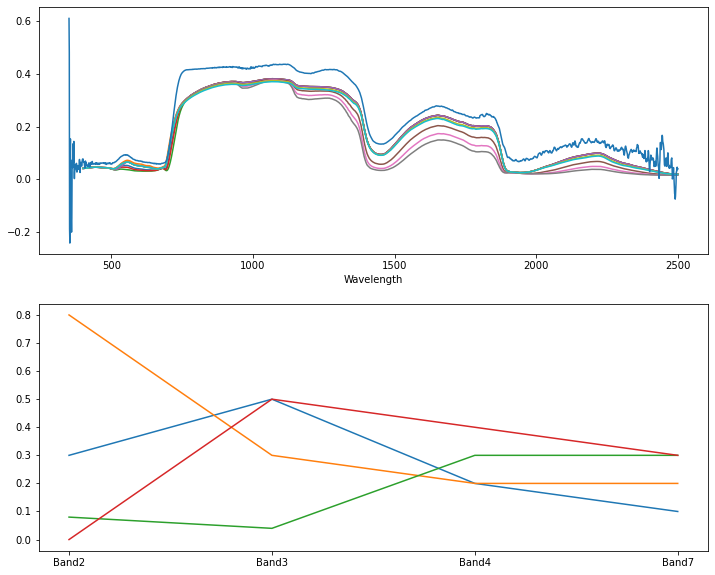

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,10))

# plot the simulated spectra
main_dataframe.plot.line(ax=ax1)
# Plot the measured spectra
measured_spectra1.plot.line(ax=ax1)
# plot the Sentinel 2 spectra
for index, row in df.iterrows():
    ax2.plot(row, label = row.name)

ax1.get_legend().remove()

plt.show()

***

<div class="alert alert-block alert-danger">
    Exercise 2: compare the simulated spectra with the real spectra
    
- Describe the main differences between the measured and the simulated spectra.
- Where do the spectra differ the most? What do you think the main causes of discrepancy between the spectra can be?
- What do you think is the effect of the *Leaf structure parameter: N* on the spectra? Remember that you didn't change this parameter to create your simulations.  

</div>  

***
## Additional information

**License:** The code in this notebook was modified by Nicolas Younes and Chad Burton. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle site 

**Last modified:** September 2022